# Notebook to reproduce the make_runoff Script produced by JB

In [1]:
# Set recursion limit in some cases we may hit this but I think it is probably a bug if we hit the recursion limit
import sys
sys.setrecursionlimit(15000)

Import the necessary libraries, notably `xarray` some `scipy` and `holoviews` for viewing

In [2]:
import xarray as xr
import numpy

from scipy.signal import convolve2d
from scipy.ndimage import measurements
from skimage.morphology import reconstruction
from skimage.segmentation import watershed

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 10

import holoviews as hv
import hvplot.xarray
from holoviews import opts
opts.defaults(
    opts.Image(
        # Values taken from holoviews.Store.custom_options for a xarray.Dataset.hvplot()
        colorbar=True,
        logx=False,
        logy=False,
#         responsive=True,
        aspect=2,
        shared_axes=True,
        show_grid=False,
        show_legend=True,
        height = 400,
        tools=['hover','lasso_select', 'box_select'], # Default = hover 
        cmap='viridis',
    )
)

import bokeh
bokeh.io.output_notebook()



Loading BokehJS ...

Create a small array that is used to look up the next cell from trip values this should be equivalent to JB's `inc` array but with python indexing and not formating

Trip values:

6|5|4
---|---|---
7|0|3
8|1|2


First axis increments

-1|-1 |-1
-|-|-
0|0|0
1|1|1

Second axis increments

-1|0|1
-|-|-
-1|0|1
-1|0|1

In [3]:
next_downstream_cell = numpy.array([
    #0  1  2  3   4   5   6   7   8
    [0, 1, 1, 0, -1, -1, -1,  0,  1],
    [0, 0, 1, 1,  1,  0, -1, -1, -1]
]).T

Load Results produced by JB routine to compare

In [4]:
ds_runoff = xr.open_dataset('~/Downloads/WESLEY/runoff_60Ma.nc')
ds_runoff

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    rtm      (lat, lon) float64 ...
    topo     (lat, lon) float64 ...
    cmsk     (lat, lon) int32 ...

 Load base test results

In [5]:
ds = xr.open_dataset('~/Downloads/WESLEY/60Ma_bil_netcdf-editor.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    topo     (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.7.2 (http://mpimet.mpg.de/...
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdconvert
    description:  Grid reconstructed using R[lon lat omega] = 125.3 0 17.1
    GMT_version:  5.4.4 (r20314) [64-bit] [MP]
    CDO:          Climate Data Operators version 1.7.2rc6 (http://mpimet.mpg....
    history:      Wed Dec  2 12:36:59 2020: ncrename -v z,topo 60Ma_bil.nc\nW...
    NCO:          "4.6.0"

Quick function that returns the 8 adjacent cells coordinates and their values

In [6]:
def get_adjacent_coords(i, j, arr):
    imax, jmax = arr.shape
    if j == jmax - 1:
        jp1 = 0
    else:
        jp1 = j + 1
    if j == 0:
        jm1 = jmax - 1
    else:
        jm1 = j - 1
        
    ip1 = numpy.min((i + 1, imax - 1))
    im1 = numpy.max((0, i - 1))
    
    return numpy.array(numpy.meshgrid([im1, i, ip1], [jm1, j, jp1], indexing='ij')).reshape(2, -1).T

def get_adjacent_values(i, j, arr):
    return numpy.array([arr[ii,jj] for ii,jj in get_adjacent_coords(i,j, arr)]).reshape(3, -1)

Fixing the topography so there are no depressions

In [7]:
def fill_depressions_in_topo(dem):
        # Copy the values to make sure we are not editing the original values
        dem = numpy.copy(dem)
        # Set Antartic values (row 0) with the maximum value of each column for the first two rows
        # This should ensure that water will never run towards to pole
        # We increment the value slightly to ensure it is not flat
        dem[0] = numpy.max(dem[:2], axis = 0) + 1.
        # Copy the map to either side for east - west periodicity
        # Rather than hard coding the periodicity as the array is small and 
        # the function runs quickly we fix the topography aligned 3 times next to each other
        dem = numpy.hstack((dem, dem, dem))
        
        # Create a pad of one all the way around the dem and set to max value
        # Scipy reconstruction works bby eroding awy the values
        # See here: https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_holes_and_peaks.html#sphx-glr-auto-examples-features-detection-plot-holes-and-peaks-py
        padded = numpy.pad(dem , 1, 'maximum')
        seed = numpy.copy(padded)
        # Add borders
        seed[1:-1, 1:-1] = dem.max() + 1

        filled = reconstruction(seed, padded, method='erosion')
        # Because we padded the array we need to remove this
        filled = filled[1:-1, 1:-1]
        # Reset the ocean -> dont modify the ocean
        filled[dem <= 0] = dem[dem <= 0]
        # Take the middle array (we stacked 3 of them next to each other)
        filled = filled[: , int(filled.shape[1] / 3) : 2 * int(filled.shape[1] / 3)]
        return filled
    
def fix_topo(dem):
    """
    This doesnt work because it applys a gradient to flat regions and modifies the values too much
    """
    from pysheds.grid import Grid
    from affine import Affine
    
    affine = Affine(1, 0, -180, 0, 1, -90)
    grid = Grid(affine=affine)
    grid.add_gridded_data(data=dem, data_name='dem', affine=affine, shape=dem.shape, crs='EPSG:4326')
    grid.mask = dem > 0
    
    # Fix Topo
    grid.fill_depressions(data='dem', out_name='filled', apply_mask=True)
    grid.resolve_flats(data='filled',out_name='resolved', apply_mask=True)
    
    topo = numpy.array(grid.resolved)
    topo[dem <= 0] = dem[dem <= 0]
#     for coord in numpy.argwhere(numpy.isnan(topo)):
#         topo[coord[0], coord[1]] = numpy.nanmean(get_adjacent_values(coord[0], coord[1], topo))
    return topo
    
topo = fill_depressions_in_topo(ds.topo.values)
hv.Image(topo).opts(cmap='terrain', symmetric=True, color_levels=20)

:Image   [x,y]   (z)

When comparing values to JB's routine there are differences only in the first row (Antartic)

In [8]:
diffs = ds_runoff.topo.values - topo
diffs[diffs == 0] = numpy.nan
hv.Image(diffs).opts(symmetric=True)

:Image   [x,y]   (z)

Notice only diffs in first row so all the rest are the same

In [9]:
numpy.all(numpy.isnan(diffs), axis=1)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Calculate orog values

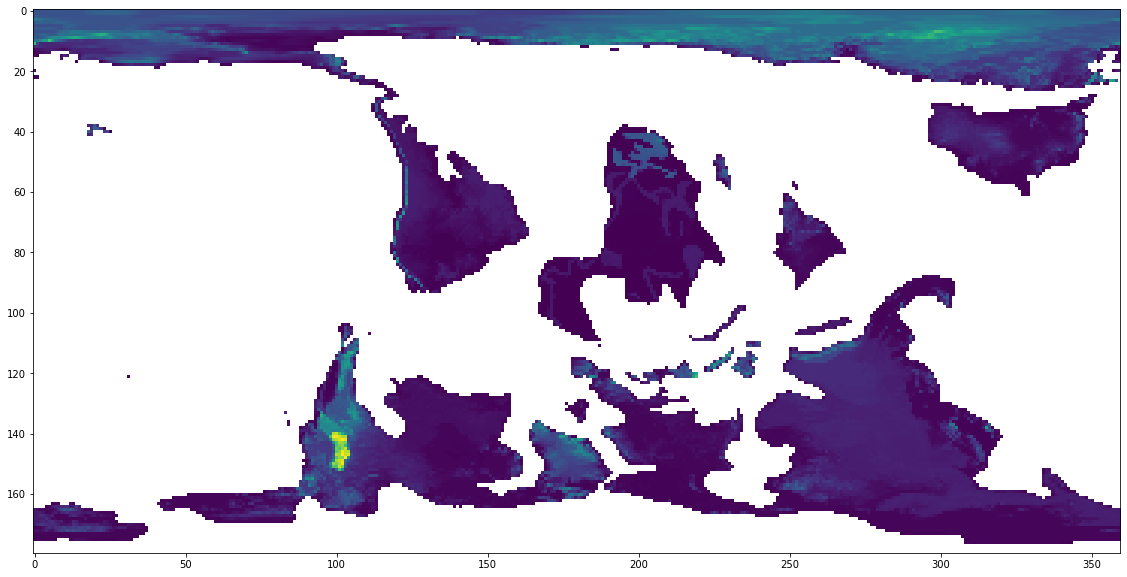

In [10]:
orog = topo.copy()
orog[orog <= 0] = numpy.nan
plt.imshow(orog)

Calculate omsk

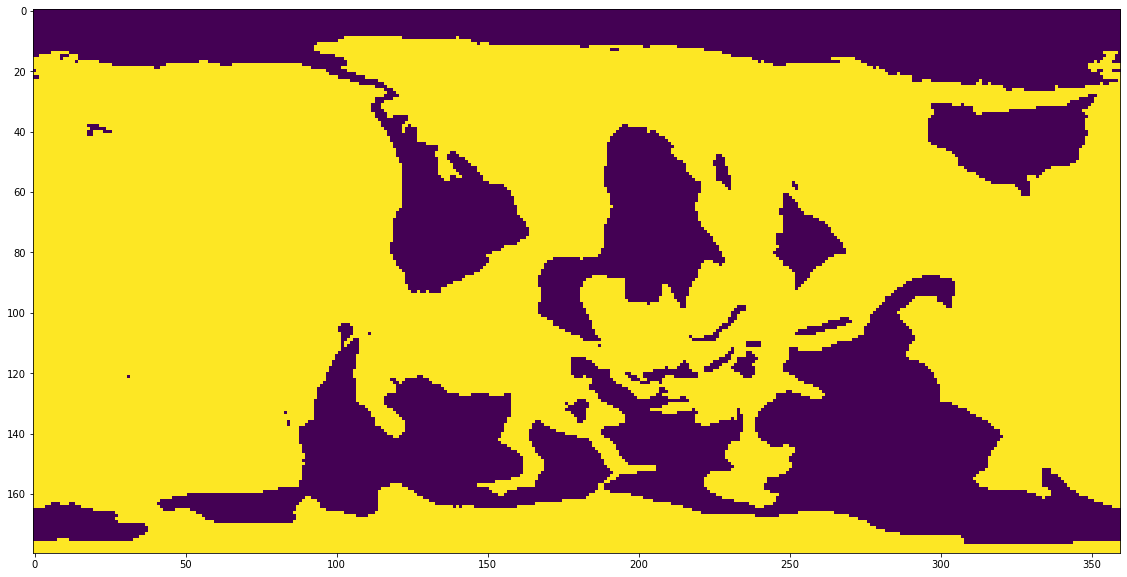

In [11]:
omsk = numpy.zeros(topo.shape)
omsk[numpy.isnan(orog)] = 1
plt.imshow(omsk)

In [12]:
def get_padded_array(arr, ensure_gradient = False):
    # Add a pad of 1 around the edge and use the wrap method
    padded = numpy.pad(arr, 1, 'wrap')
    # Fix the Top and bottom because they are the same value as before and not wrapped (there is no North/South wrapping)
    padded[0] = padded[1]
    padded[-1] = padded[-2]
    if ensure_gradient:
        padded[0] += 1.
        padded[-1] += 1
    return padded

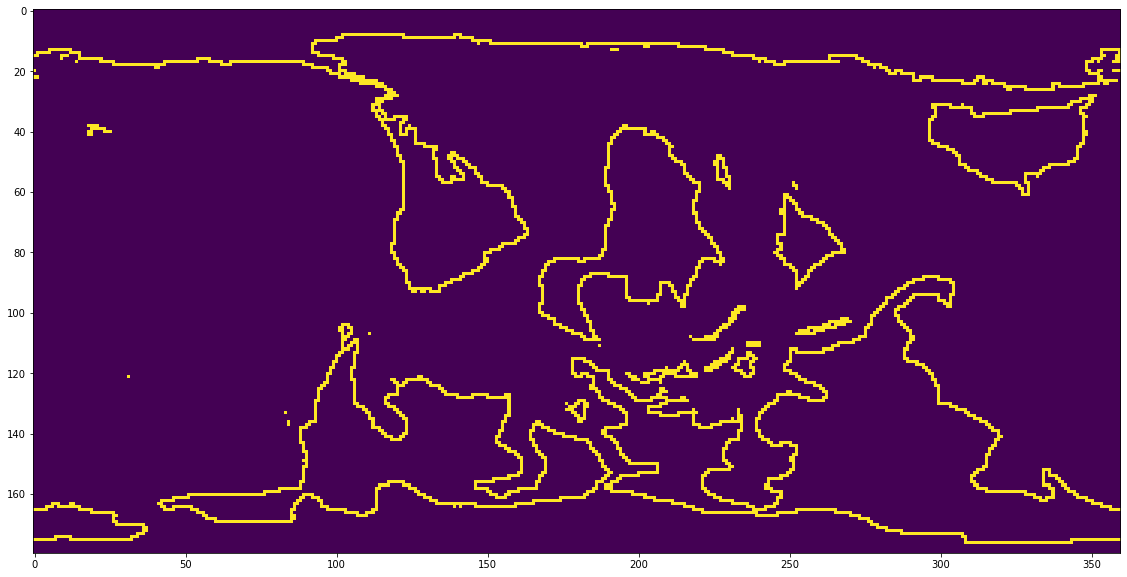

In [13]:
def calculate_cmsk():
    template = numpy.ones(9).reshape(3,3)
    # pad the array so we don't have to worry about edge cases
    is_water = get_padded_array(omsk).astype(bool)
    # Calculate the convolution
    conv = convolve2d(is_water, template, 'same')
    # Extract the values we want
    # Conv is positive where one of the adjacent cells is ocean
    # We only want land cells
    res = (conv > 0) & (~is_water)
    # We padded omsk so as to not worry about the periodicity
    # Now we have to remove the padding
    res = res[1:-1, 1:-1]
    return res

cmsk = calculate_cmsk()
plt.imshow(cmsk)

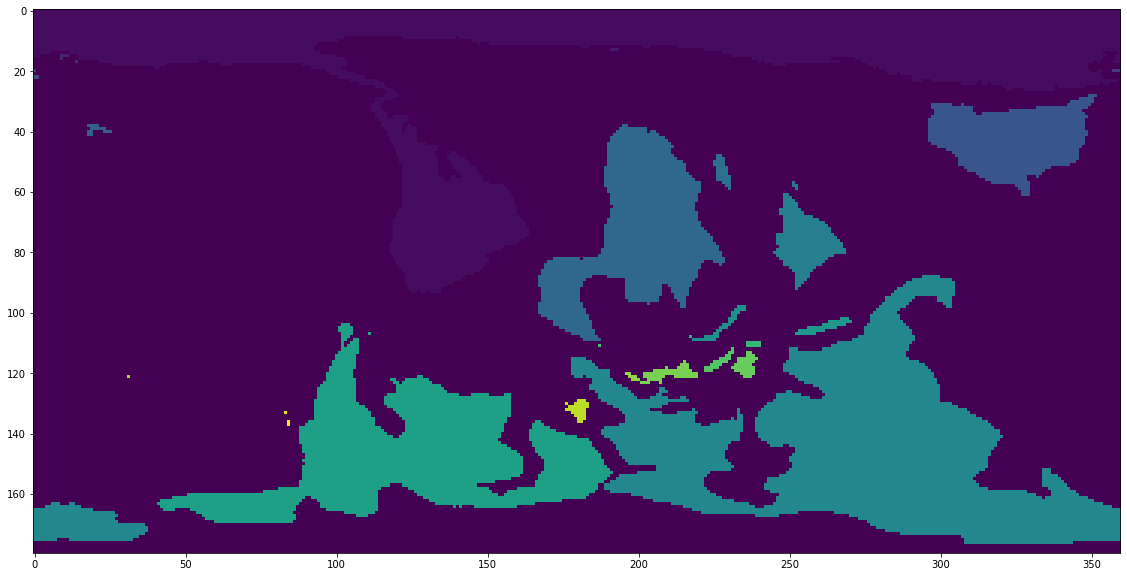

In [14]:
def calculate_continents():
    # Calculate the continents measurements returns a list of distinct objects in the image
    continents = measurements.label(~omsk.astype(bool))[0]
    # Take a look at the edges and see where continents are different and should be the same due to cyclicite
    difference_long_180 = numpy.argwhere((continents[:, 0] != continents[:, -1]) & # Check first column and last column are the same
                           (continents[:, 0] != 0) & # Make sure the first column isn't ocean -> last column is a coast
                           (continents[:, -1] != 0) # Make sure the last column isn't ocean -> first column is a coast
                          ).flatten()
    same_continents = []
    for d in difference_long_180:
        vals = [continents[d, 0], continents[d, -1]]
        inserted = False
        for i in range(len(same_continents)):
            conts = same_continents[i]
            # At least one of the values already exists in a list
            if len(set(vals) & set(conts)):
                conts.extend(vals)
                same_continents[i] = list(set(conts))
                inserted = True
                break
        # If the continents haven't already been seen then add a new continent to the list
        if not inserted:
            same_continents.append(vals)

    for cont in same_continents:
        # Replace all values in continents with the first value
        for i in range(1, len(cont)):
            continents[continents == cont[i]] = cont[0]
    return continents

continents = calculate_continents()
plt.imshow(continents)

In [15]:
def calculate_rtm_slow():
    """This probably shouldn't be used
    """
    # set out the trip corresponding values
    rtm_values = numpy.array([6, 5, 4, 7, 0, 3, 8, 1, 2])
    # Pad the array, this means we don't need to worry about checkng the EW periodicity
    padded_topo = get_padded_array(topo, ensure_gradient=True)
    # Create an empty results array
    rtm = numpy.empty(topo.shape)
    # Loop over all rows
    for i in range(1, topo.shape[0]+1):
        # Loop over all columns
        for j in range(1, topo.shape[1]+1):
            # Find the adjacent topography values (get_adjacent_value)
            # The smallest value means that it is the biggest drop this is the direction we need to use rtm_values to look up the corresponfding trip value
            #TODO There could be problems here if the point is lower than all other points -> sink this should have been fixed in the topo
            rtm[i-1,j-1] = rtm_values[numpy.argmin(get_adjacent_values(i, j, padded_topo))]
    # Only take values where omsk is defined
    return numpy.where(omsk == False, rtm, numpy.nan)

rtm_slow = calculate_rtm_slow()
hv.Image(rtm_slow)

:Image   [x,y]   (z)

Quick visual comparison to make sure the values are reasonable

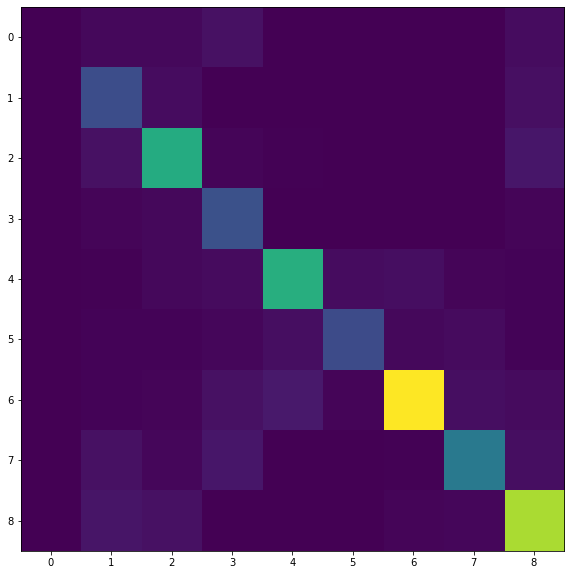

In [16]:
vals = numpy.array([rtm_slow.flatten(), ds_runoff.rtm.values.flatten()]).T
vals[numpy.isnan(vals)] = -1
vals = vals.astype(int)

binned = numpy.zeros((10,10))
for ij in vals:
    i, j = ij
    i +=1
    j +=1
    binned[i, j] += 1
    
plt.imshow(binned[1:, 1:])

# Quicker way of calculating rtm using arrays

This is the desired routing to use that does not work

<div class='alert alert-danger'>
There seems to be a small bug here still
</div>

In [17]:
def migrate_front_across_flats(front, tmp_trip, arrays, trip_values):
    """
    Recursive function to propagate values across a front. We use recursion rather than a while loop
    """
    # Get the adjacent cells that have the same value as the center cell
    # arrays is defined below and is a 8 by i by j where 8 corresponds the the different directions
    # each layer of arrays corresponds to the difference in the trip value in that direction eg layer one is the differences with cells to the north
    flat_coords = numpy.argwhere(arrays[:, front[0], front[1]].T == 0)
    # if there are no more cells with adjacent flat cells then stop the recursion
    if not len(flat_coords):
        return
    
    # Get the adjacent cell coordinates by using where the flat cell is in comparison to the each cell on the front
    # Downstream cells points to the combination of -1, 0, 1 in each direction that needs adding
    next_cells = next_downstream_cell[trip_values[flat_coords[:, 1]]] + front.T[flat_coords[:, 0]]
    # Fix the EW periodicity
    # Replace values that are -1 with the last value
    next_cells[:, 1] = numpy.where(next_cells[:, 1] == -1, tmp_trip.shape[1] - 1, next_cells[:, 1])
    # Replace values that go off the end with 0
    next_cells[:, 1] = numpy.where(next_cells[:, 1] == tmp_trip.shape[1], 0, next_cells[:, 1])

    # Remove duplicate cells that can be found from multiple routes 
    # This takes the first occurence each time -> means that the trip values aren't going to be random 
    # They are probably ordered in the following order 6, 5, 4, 7, 0, 3, 8, 1, 2 (trip values order)
    next_cells, unique_ids = numpy.unique(next_cells, axis=0, return_index=True)
    # Add the trip values to the next cells this is for consitent filtering
    next_cells = numpy.hstack((next_cells, trip_values[flat_coords[unique_ids, 1]].reshape(-1, 1)))
    # Make sure we don't have any values that go outside the array 
    #TODO this may be casuing problems ??? but hopefully isn't being hit
    next_cells = next_cells[(next_cells[:, 0] >= 0) & (next_cells[:, 0] < topo.shape[0]) & (next_cells[:, 1] >= 0) & (next_cells[:, 1] < topo.shape[1])]
    # only take values that haven't already been seen
    # We do this by checking if a value for the cell has been set -> this means it has been seen in another layer of the recursion
    # trip values are 1-> 8 this means that anythin 0 or below hasn't been seen
    next_cells = next_cells[tmp_trip[next_cells[:, 0], next_cells[:, 1]] <= 0] 
    # Change the values of the next cells to their correct trip values (calculated where they came from)
    tmp_trip[next_cells[:, 0], next_cells[:, 1]] = next_cells[:, 2]
    # Redo this function as many times as necessary
    return migrate_front_across_flats(next_cells[:, :2].T, tmp_trip, arrays, trip_values)

def calculate_rtm():
    """
    calculate trip values using matrices rather than loops
    """
    # Pad the array so that we don't worry about EW periodicity
    arr = get_padded_array(topo, ensure_gradient=True)
    # Set the trip values, this is in case we don't use a standard order in arrays
    trip_values = numpy.array([1,2,3,4,5,6,7,8])
    # Calculate columnwise differences -> NS differences
    NS = (arr[1:] - arr[:-1])
    # Calculate rowwise differnces -> EW differences
    EW = (arr[:, :-1] - arr[:, 1:])
    # Calculate diagonals
    NESW = arr[1:, 1:] - arr[:-1, :-1] 
    SENW = arr[1:, :-1] - arr[:-1, 1:]
    
    # Put it all into a multidimensional array
    # Because we calculated differences in different directions we need to take parts of each array
    # Also because we calculated the difference in one direction the value in the other direction is the symmetric (*-1)
    # Big positive values means the biggest differences -> direction of descent
    arrays = numpy.array([
                            NS[1:, 1:-1] * -1 ,
                            NESW[1:, 1:] * -1, 
                            EW[1:-1, 1:],
                            SENW[:-1, 1:],
                            NS[:-1, 1:-1],
                            NESW[:-1, :-1], 
                            EW[1:-1, :-1] * -1,
                            SENW[1:, :-1] * -1,
                          ])

    
    # Find the index of the biggest value -> direction of descent if multiple values occur it takes the smallest (first seen)
    ind = numpy.argmax(arrays, axis=0) 
    # Convert indexs to trip values
    rtm = trip_values[ind].astype(float)
    # only take rtm values on land
    rtm[omsk == True] = numpy.nan
    
    # Fix the values on flats
    is_pas = numpy.sum(arrays > 0, axis=0) > 0 # There is at least one cell where the water can flow downwards pas is like in the mountains not quite a col but like a suspended glacial valley
    # A pas has a least one value that is greater than 0 -> downwards flow
    is_flat = numpy.sum(arrays == 0, axis=0) > 0 # Flats are defined by areas where at least the difference between 2 cells is 0

    # Only take land cells
    is_pas[omsk == 1] = False
    is_flat[omsk == 1] = False

    # Exit points from flat basins are defined as the points that have the same altitude as a neighbor cell (is_flat) and at least one downward cell (is_pas)
    exit_points = numpy.array(numpy.where((is_pas == True) & (is_flat == True)))
    
    # Store a tempoorary array as to not override the results
    # This is passed to our recursively function and filled over time
    tmp_trip = numpy.zeros(topo.shape)

    # Calculate the values at the exit points
    # This is the same values as currently in rtm
    rtm_values = trip_values[numpy.argmax(arrays[:, exit_points[0], exit_points[1]], axis=0)]
    # Add the values to tmp_trip this is so the algo knows that these cells ahev already been seen and will expand / migrate from here
    tmp_trip[exit_points[0], exit_points[1]] = rtm_values

    # Migrate the front across the flats recursively
    migrate_front_across_flats(exit_points, tmp_trip, arrays, trip_values)
    
    # Replace values in rtm by the new updated flats values
    rtm[is_flat == 1] = tmp_trip[is_flat == 1]
    
    # The first row (Antartic) is considered to be the pole so say everything goes north from there
    rtm[0] = numpy.where(~numpy.isnan(rtm[0]), 1, numpy.NaN)
    
    # The last row (Artic) is considered to be the pole so say everything goes South from there
    rtm[-1] = numpy.where(~numpy.isnan(rtm[-1]), 5, numpy.NaN)
    
    return rtm, is_flat

rtm, is_flat = calculate_rtm()
hv.Image(rtm) + hv.Image(is_flat == 1)

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

The trip values calculated using differences do not account for flats. The `argmax` returns the first occurence. In zones with no gradients this can lead to cells pointing to each other that need to be fixed.

In [18]:
# Check in not flat regions to see how the values compare
rtms = rtm.copy()[~is_flat]
truth = ds_runoff.rtm.values[~is_flat]
vals = numpy.array([rtms.flatten(), truth.flatten()]).T
vals[numpy.isnan(vals)] = -1
vals = vals.astype(int)

binned = numpy.zeros((10,10))
for ij in vals:
    i, j = ij
    i +=1
    j +=1
    binned[i, j] += 1
    
hv.Image(binned[1:, 1:])

:Image   [x,y]   (z)

In [19]:
# See why so many 5 and 6 get mixed up?
bad_vals = numpy.array(numpy.where((rtm == 5) & (ds_runoff.rtm.values == 6)))

In [20]:
for k in range(bad_vals.shape[1]):
    ii, jj = bad_vals[:, k]
    diffs = get_adjacent_values(ii, jj, topo) - topo[ii, jj]
    # there seems to be lots of differnces on coasts ??? Need to check this further why there are differe
    if (diffs[0, 0] != diffs[0, 1]) & (get_adjacent_values(ii, jj, topo)[0,0] > 0):  
        print(k, ii, jj)
        print(diffs[0, 0], diffs[0, 1])
        print(diffs)


263 158 213
0.0 1.0
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [21]:
kk = 263
ii, jj = bad_vals[:, kk]
bad_vals[:, kk]

array([158, 213])

In [22]:
get_adjacent_values(ii, jj, rtm)

array([[5., 1., 4.],
       [6., 5., 2.],
       [7., 6., 2.]])

In [23]:
get_adjacent_values(ii, jj, topo)

array([[46., 47., 47.],
       [46., 46., 47.],
       [46., 46., 47.]])

In [24]:
bad_vals[0, kk]

158

In [25]:
get_adjacent_values(ii, jj, ds_runoff.topo.values)

array([[46., 47., 47.],
       [46., 46., 47.],
       [46., 46., 47.]])

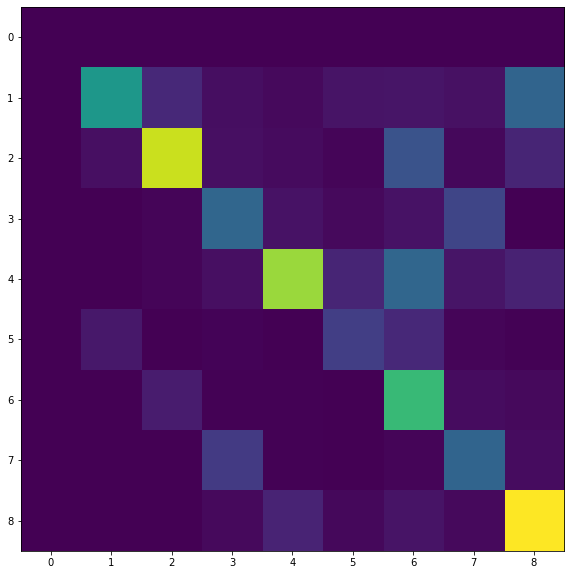

In [26]:
# General case differences
vals = numpy.array([rtm.flatten(), ds_runoff.rtm.values.flatten()]).T

vals[numpy.isnan(vals)] = -1
vals = vals.astype(int)

binned = numpy.zeros((10,10))
for ij in vals:
    i, j = ij
    i +=1
    j +=1
    binned[i, j] += 1
    
plt.imshow(binned[1:, 1:])

# PRE STN Calculations

In [27]:
# load correct basin files
ds_pre_stn = xr.open_dataset('/Users/wesleybanfield/Downloads/WESLEY/routing_60Ma_1x1_pre_stn.nc')
ds_pre_stn

<xarray.Dataset>
Dimensions:  (x: 360, y: 180)
Dimensions without coordinates: x, y
Data variables:
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    orog     (y, x) float32 ...
    trip     (y, x) float32 ...
    basins   (y, x) float32 ...
    flength  (y, x) float32 ...

In [28]:
# This is fixed but could be parameterised?
imax = 180
jmax = 360

In [29]:
# Calculate longigtude and latitude array
rlon = numpy.arange(-179.5, 180.5)
rlat = numpy.arange(89.5, -90.5, -1)
rlon, rlat = numpy.meshgrid(rlon, rlat)

setup `itrip` `iorog`

In [30]:
itrip = numpy.copy(rtm)
itrip[numpy.isnan(itrip)] = -9999
iorog = numpy.copy(topo)
iorog[iorog < 0] = -9999

# Area Calculation
Calculate area of each cell

In [31]:
rEarth = 6370

dy = (numpy.pi * rEarth) / 180
dx = (2 * numpy.pi * rEarth * numpy.cos(rlat * numpy.pi / 180)) / 360.
area = dx * dy

In [32]:
hv.Image(area).opts(tools= ['hover'])

:Image   [x,y]   (z)

# Basin Calculations

In [33]:
def get_next_cell(cells, temp_array):
    """
    Recursive function that from an given cell will find all the next down stream cells using trip values
    """
    ii, jj = cells[-1]
    #Subscripts pointing on the next cell (downstream) following trip value
    downstream_direction = next_downstream_cell[int(trip[ii, jj])]
    # Add the indexs to the original values
    ip1 = ii + downstream_direction[0]
    jp1 = jj + downstream_direction[1]
    # Handle periodicity
    if ( jp1 < 0 ): jp1 = jmax -1
    if ( jp1 >= jmax ): jp1 = 0
    next_cell = (ip1, jp1)
    if ip1 >= imax or ip1 < 0:
        print(f"Shouldn't be here, {ii}, {jj}")
        return cells, 'outside', next_cell
    # If the next cell is ocean then we are done
    if numpy.isnan(trip[next_cell]):
        return cells, 'ocean', next_cell
    # If the next cell already has a value then we are done
    if temp_array[next_cell] != 0:
        return cells, 'junction', next_cell

    # We have already come across this cell lets see if we can find a different output
    if next_cell in cells:
        return cells, 'infinite_loop', next_cell
#         possible_values = numpy.where(arrays[:, next_cell[0], next_cell[1]] == arrays[:, next_cell[0], next_cell[1]].max())[0]
#         nb_times_seen = cells.count(next_cell)
#         print(nb_times_seen, next_cell)
#         trip[next_cell] = possible_values[nb_times_seen]
    cells.append(next_cell)
    return get_next_cell(cells, temp_array)

In [34]:
# create dummy array
basins = numpy.zeros(topo.shape)
# Find the highest point
highest_point = numpy.unravel_index(numpy.where(basins == 0, topo, -9999).argmax(), topo.shape)

# Setup a basin number
basin_nb = 1

# Set trip values
trip = ds_runoff.rtm.values.copy()
#trip = rtm.copy()
# trip = rtm_slow.copy()

# While we still have points higher than 0 calculate the runoff cells from this high point
while topo[highest_point] > 0:
    # Get cells connected to current cell
    cells, end_reason, next_cell = get_next_cell([highest_point], basins)
    x, y = numpy.array(cells).T
    # If we hit a junction then we need to adjust all the values
    if end_reason == 'junction':
        basins[x, y] = basins[next_cell]
    else:
        # Set value to a new basin
        basins[x, y] = basin_nb
        basin_nb += 1
    # Calculate the next highest point
    highest_point = numpy.unravel_index(numpy.where(basins == 0, topo, -9999).argmax(), topo.shape)

# Rarrange by the area
# We use bincount with weights corresponding to the area of each cell
sizes = numpy.bincount(basins.flatten().astype(int), area.flatten())
# We sort the cells by size
sorted_sizes = numpy.argsort(sizes)[::-1]
# We assign the new value
for i in range(len(sorted_sizes)):
    basins[basins == sorted_sizes[i]] = - i

# REplace ocean with zeros
basins[basins == 0] = numpy.nan
# Flip to get positive numbers
basins *= -1


hv.Image(basins)

:Image   [x,y]   (z)

In [35]:
from panel.interact import interact
import panel as pn

def plot():
    return (
            hv.Image(ds_pre_stn.basins.values[::-1]).opts(cmap='category20',invert_axes=False)
            + hv.Image(basins).opts(cmap='Category20').redim.range(z=(0, 20))
           ).opts(hv.opts.Image(height=400, width=900)).cols(2)

plot()

:Layout
   .Image.I  :Image   [x,y]   (z)
   .Image.II :Image   [x,y]   (z)

# Compute Flow length

In [36]:
trip = ds_runoff.rtm.values

## Compute Distance in each cell

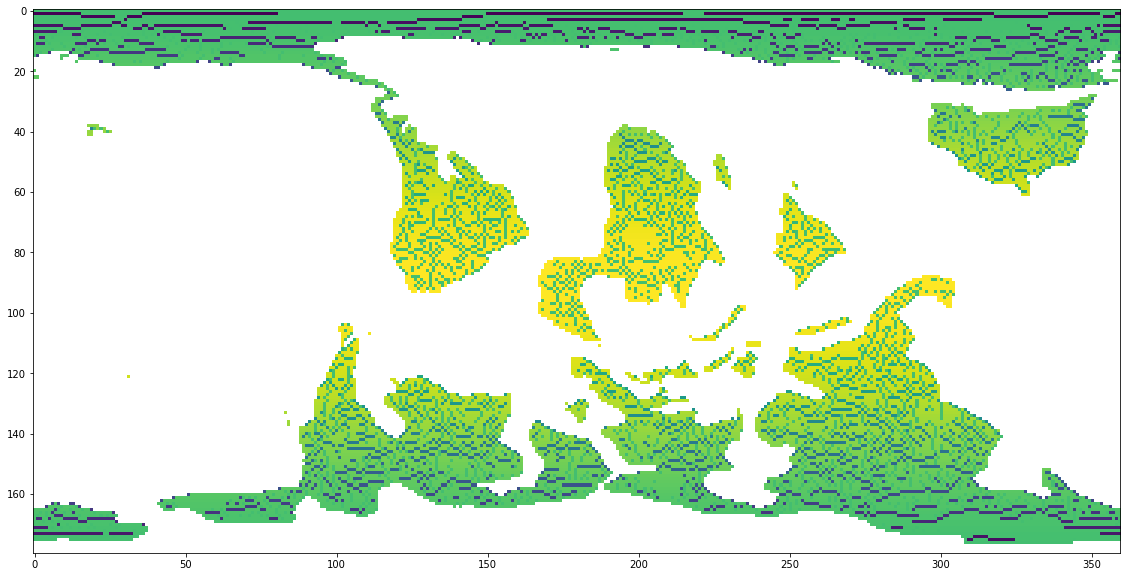

In [37]:
def calculate_distances_slow(trip, dx, dy):
    # Creat Distance for each cell based on trip values
    trip_distances = numpy.array([
        numpy.zeros(trip.shape), # Dummy used for indexing this should never be choosen
        numpy.ones(trip.shape) * dy,
        numpy.sqrt(dx ** 2 + dy ** 2),
        dx,
        numpy.sqrt(dx ** 2 + dy ** 2),
        numpy.ones(trip.shape) * dy,
        numpy.sqrt(dx ** 2 + dy ** 2),
        dx,
        numpy.sqrt(dx ** 2 + dy ** 2),
    ])
    
    # create an empty array
    distances = numpy.empty(trip.shape)
    distances[:] = numpy.nan
    # Calculate indices where distance is non null
    x, y = numpy.where(~numpy.isnan(trip))
    # Loop over values
    # TODO could this be done with some clever indexing?
    for k in range(len(x)):
        # Get cell coordinates
        i, j = x[k], y[k]
        # Find Trip value at given location
        # Take the i, j coordinates in the corresponding layer
        distances[i, j] = trip_distances[int(trip[i, j]), i, j]
    return distances

def calculate_distances(trip, dx, dy):
    # Creat Distance for each cell based on trip values
    trip_distances = numpy.array([
        numpy.zeros(trip.shape), # Dummy used for indexing this should never be choosen
        numpy.ones(trip.shape) * dy,
        numpy.sqrt(dx ** 2 + dy ** 2),
        dx,
        numpy.sqrt(dx ** 2 + dy ** 2),
        numpy.ones(trip.shape) * dy,
        numpy.sqrt(dx ** 2 + dy ** 2),
        dx,
        numpy.sqrt(dx ** 2 + dy ** 2),
    ])
    
    temp_trip = numpy.where(~numpy.isnan(trip), trip.astype(int), 0)
    xx, yy = numpy.ix_(numpy.arange(trip.shape[0]), numpy.arange(trip.shape[1]))
    distances = trip_distances[temp_trip, xx, yy]
    distances[distances == 0] = numpy.nan
    
    return distances

distances = calculate_distances(trip, dx, dy)
plt.imshow(distances)

## Compute river lenghts

In [38]:
flength = numpy.empty(trip.shape)
flength[:] = numpy.nan

In [39]:
# We store the outflow points as they are used later to determine trip values
# They could be calculated using minimum topo height inside each basin but this has problems
# When the outflow point is at the same height as other points
# Considering we are following flow directions we will just store the values
outflow_points = []
for k in range(numpy.nanmin(basins).astype(int), numpy.nanmax(basins).astype(int) + 1):
    tmpbas = numpy.where(basins == k)
    nboutflow = 0
    outloc = [numpy.nan, numpy.nan]
    
    # Calculate the nb of outflow points
    x, y = numpy.where(basins == k)
    for k in range(len(x)):
        i, j = x[k], y[k]
        downstream_direction = next_downstream_cell[int(trip[i, j])]
        # Add the indexs to the original values
        ip1 = i + downstream_direction[0]
        jp1 = j + downstream_direction[1]
        # Handle periodicity
        if ( jp1 < 0 ): jp1 = jmax -1
        if ( jp1 >= jmax ): jp1 = 0
        next_cell = (ip1, jp1)
        if  ~numpy.isnan(trip[i, j]) & numpy.isnan(trip[next_cell]):
            if outloc != [i, j]:
                outloc = [i, j]
                nboutflow += 1
    outflow_points.append(outloc)
                
                        
    if nboutflow > 1:
        print("error occured to many outflow points")
    elif nboutflow == 0:
        print("No outflow points")

outflow_points = numpy.array(outflow_points)

In [40]:
# create dummy array
flength = numpy.zeros(trip.shape)
# Find the highest point
highest_point = numpy.unravel_index(numpy.where(flength == 0, topo, -9999).argmax(), topo.shape)

# While we still have points higher than 0 calculate the runoff cells from this high point
while topo[highest_point] > 0:
    # Get cells connected to current cell
    cells, end_reason, next_cell = get_next_cell([highest_point], flength)
    # We reverse the order of cells because the last one seen is the closest to the ocean
    x, y = numpy.array(cells[::-1]).T
    # We take the distance according to trip in each cell to the next cell
    # We calculate the cumlative sum along the flow path
    flow_lengths = numpy.cumsum(distances[x, y])
    
    if end_reason == 'junction':
        # If we hit a junction then we need to adjust all the values because we are not starting at 0
        flength[x, y] = flength[next_cell] + flow_lengths
    elif end_reason == 'ocean':
        # The outlet is an ocean
        flength[x, y] = flow_lengths

    else:
        print("Shouldn't be here")
    # Calculate the next highest point
    highest_point = numpy.unravel_index(numpy.where(flength == 0, topo, -9999).argmax(), topo.shape)

# Add nan values for the ocean
flength[omsk == 1] = numpy.nan

hv.Image(flength)

:Image   [x,y]   (z)

In [41]:
# Check values are very close the diffs are due to float handling
numpy.nanmax(ds_pre_stn.flength.values[::-1] - flength)

0.0017688857574285066

## Check `nav_lat` and `nav_lon`

In [42]:
numpy.all(rlon == ds_pre_stn.nav_lon)

<xarray.DataArray 'nav_lon' ()>
array(True)

In [43]:
numpy.all(rlat == ds_pre_stn.nav_lat)

<xarray.DataArray 'nav_lat' ()>
array(True)

# STN convert Paleo

In [44]:
ds_stn = xr.open_dataset('/Users/wesleybanfield/Downloads/WESLEY/routing_60Ma_1x1_full_var.nc')
ds_stn

<xarray.Dataset>
Dimensions:  (x: 360, y: 180)
Dimensions without coordinates: x, y
Data variables:
    nav_lon  (y, x) float32 ...
    nav_lat  (y, x) float32 ...
    trip     (y, x) float32 ...
    basins   (y, x) float32 ...
    topoind  (y, x) float32 ...
    hdiff    (y, x) float32 ...
    riverl   (y, x) float32 ...
    orog     (y, x) float32 ...
    disto    (y, x) float32 ...

In [45]:
trip_backup = trip.copy()

In [46]:
trip = trip_backup.copy()

In [47]:
# This is how it is done in the prexisting scripts but we have alreay calculated outflow points so we will just use that

# for i in range(numpy.nanmin(basins).astype(int), numpy.nanmax(basins).astype(int)):
#     exit_point = numpy.unravel_index(numpy.argmin(numpy.where(basins == i, topo, topo.max())), trip.shape)
#     trip[exit_point] = 9

# Just use the values that have already been stored
trip[outflow_points[:, 0],outflow_points[:, 1]] = 9

In [48]:
x, y = outflow_points.T

for k in range(len(x)):
    i, j = x[k], y[k]
    adjacent_coords = get_adjacent_coords(i, j, trip)
    ip1, jp1 = numpy.max(adjacent_coords, axis=0)
    im1, jm1 = numpy.min(adjacent_coords, axis=0)
    
    adjacent_basins_values = get_adjacent_values(i, j, basins)
    basbas = [adjacent_basins_values[1, 1], adjacent_basins_values[2, 2], adjacent_basins_values[1, 2], adjacent_basins_values[2, 1]]
    
    adjacent_trip_values = get_adjacent_values(i, j, trip)
    trptrp = [adjacent_trip_values[1, 1], adjacent_trip_values[2, 2], adjacent_trip_values[1, 2], adjacent_trip_values[2, 1]]
    
    if ((basbas == basbas[0]).sum() == 4) & ((trptrp == trptrp[0]).sum() == 4):
        # Count how many ocean cells are in each of the corners
        ocean_in_box = [
         (~numpy.isnan(get_adjacent_values(im1, jm1, basins))).sum(), # Upper left
         (~numpy.isnan(get_adjacent_values(im1, jp1, basins))).sum(), # Upper right
         (~numpy.isnan(get_adjacent_values(ip1, jp1, basins))).sum(), # Lower Right
         (~numpy.isnan(get_adjacent_values(ip1, jm1, basins))).sum(), # Lower Left
        ]
        li = numpy.argmax(ocean_in_box)
        if li == 0:
            trip[i, j] = 9
            trip[ip1, j] = 7
            trip[ip1, jp1] = 8
            trip[i, jp1] = 1
        elif li == 1:
            trip[i, j] = 3
            trip[ip1, j] = 9
            trip[ip1, jp1] = 1
            trip[i, jp1] = 2
        elif li == 2:
            trip[i, j] = 4
            trip[ip1, j] = 5
            trip[ip1, jp1] = 9
            trip[i, jp1] = 3
        else:
            trip[i, j] = 5
            trip[ip1, j] = 6
            trip[ip1, jp1] = 7
            trip[i, jp1] = 9

In [49]:
# We have modified the outflow points in the last part of code so outflow points are no longer correct
# We need to find trip values equal to 9
x, y = numpy.where(trip == 9)

# We pad the arrays twice because we are looking at the 5 x 5 grid centered at the point where trip is equal to 9
# If we don't pad twice then we will have problems on the borders
padded_omsk = get_padded_array(omsk) # pad 1 value
padded_omsk = get_padded_array(padded_omsk) # pad 2 value

padded_trip = get_padded_array(trip) # pad 1 value
padded_trip = get_padded_array(padded_trip) # pad 2 value

for k in range(len(x)):
    i, j = x[k], y[k]
    # To get the five values centered on i, j we need to go from i - 2 -> i + 3
    # has we have padded twice we need to add 2 so the indexs match
    omsk_bx = padded_omsk[i-2+2:i+3+2, j-2+2:j+3+2]
    trip_bx = padded_trip[i-2+2:i+3+2, j-2+2:j+3+2]
    
    # If there is at least one ocean point then it is a coastal or river flow
    # Ocean values are 1 in omsk
    if numpy.sum(omsk_bx) > 0:
        # The first 200 basins are river flow else it is coastal flow
        if basins[i, j] < 200:
            trip[i, j] = 99
        else:
            trip[i, j] = 98
    elif numpy.sum(omsk_bx < 0.5) > 0:
        # This can only be an internal basin
        # Greenland is still a problem as we have coarse resolution coast lines
        # Thus anything north of 60deg N will be coastal flow
        if rlat[i, j] > 60:
            trip[i, j] = 98
        else:
            trip[i, j] = 97
    # Not sure we every hit this?
    else:
        print("We have an ouflow point but we can not say if it is return flow or flow to the ocean")        
        print(i, j)
        print(omsk_bx)
        print(trip_bx)